In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import os
import numpy as np
import mesonet_calculations
from scipy import interpolate
from mpl_toolkits.basemap import Basemap, cm
from plotting import sfc_plot

In [3]:
import scipy.stats as stats
import metpy.calc as mcalc
from metpy.units import units
matplotlib.rcParams.update({'font.size':8})

In [4]:
# Set outside file locations
shapefile = 'UScounties/UScounties' # Background map
location_filename = 'locations.txt' # Mesonet station locations
data_dir = 'raw_data' # Where all the raw data files are stored

### Read things in

In [5]:
# Locations of all mesonet locations
locations = pd.read_csv(location_filename, sep='	')

In [6]:
# Set time period of interest
starttime = dt.datetime(2012,6,4,17)
endtime   = starttime + dt.timedelta(hours=6)
interval  = int((endtime - starttime).total_seconds()/300)

In [7]:
met = pd.DataFrame()
dir = os.listdir(data_dir)
for file in dir:
    if file[-4:] == '.txt':
#         print(file)
        met = pd.concat([met, mesonet_calculations.meso_operations('{0}/{1}'.format(data_dir,file), 
                                                                   starttime,endtime,locations)], axis=0)

In [8]:
variables = {'temperature' : ('Degrees Celsius', '2 m Temperature'),
             'pressure': ('Milibars', 'Sea Level Pressure'),
             'dew_point': ('Degrees Celsius', 'Dewpoint'),
             'wind_speed': ('Meters per second', '10 m Scalar wind Speed'),
             'gust_speed': ('Meters per second', '10 m Gust Wind Speed'),
             'rainfall': ('Inches', 'Rainfall'),
             'soil_t': ('Degrees Celsius', '10 cm Natural Soil Temperature'),
             'soil_m': ('Approximate Percentage', '20 cm Water Content')
             }

### Basic interpolation and surface plot

In [9]:
time_selection = dt.datetime(2012, 6, 4, 19, 0) ## Choose date/time for single plot

In [10]:
# Make a grid for manual plot interpolation
xmin = np.min(met['Lon'])
xmax = np.max(met['Lon'])
ymin = np.min(met['Lat'])
ymax = np.max(met['Lat'])
xi, yi = np.meshgrid(np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200))

In [11]:
# Variable for plotting
z_max = np.max(met['Theta_e'])
z_min = np.min(met['Theta_e'])
levels = np.arange(z_min, z_max+1, 1)

zi = interpolate.griddata((met.loc[time_selection]['Lon'], 
                           met.loc[time_selection]['Lat']), 
                           met.loc[time_selection]['Theta_e'], 
                          (xi, yi), method='linear') # May not want the linear interpolation, change here

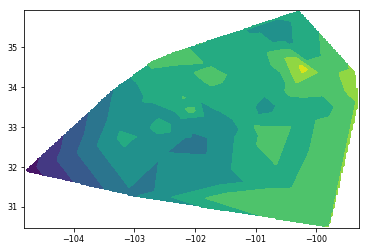

In [12]:
plt.contourf(xi, yi, zi) # Quick plot test

If using Python 3 and old basemap, floats may need to be changed to integers in the source code:
https://stackoverflow.com/questions/44852382/indexerror-when-using-some-projections-with-basemap-and-contourf-in-python-3-6-1

/localdata/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/localdata/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/localdata/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/localdata/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/localdata/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3799: MatplotlibDeprecationWarni

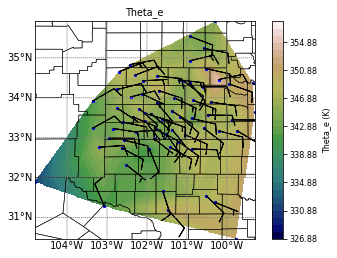

In [13]:
maps = Basemap(llcrnrlon=xmin, llcrnrlat=ymin, urcrnrlon=xmax, urcrnrlat=ymax, projection='cyl')
maps.readshapefile(shapefile, name='counties')

maps.contourf(xi, yi, zi,levels, latlon=True, cmap = plt.cm.gist_earth)
c = plt.colorbar()
c.set_label('Theta_e (K)') 
# Plot some wind barbs in knots, raw data is in m/s
maps.scatter(met.loc[time_selection]['Lon'], met.loc[time_selection]['Lat'], marker='o', c='b', s=5)
maps.barbs(  met.loc[time_selection]['Lon'], met.loc[time_selection]['Lat'], 
             met.loc[time_selection]['u'].values*1.94384, met.loc[time_selection]['v'].values*1.94384)
maps.drawparallels(np.arange(31.,36,1.), color='0.5',labels=[1,0,0,0], fontsize=10)
maps.drawmeridians(np.arange(-104.,-98.,1.), color='0.5',labels=[0,0,0,1], fontsize=10)

plt.title('Theta_e') 
plt.show()

### Example for plotting a smaller region
Implemented in single_meso_surface.py

In [14]:
time_selection = dt.datetime(2012, 6, 4, 19, 0) ## Choose date/time for single plot

# Set plot bounds
xmin = -103.3
xmax = -100.9
ymin = 33.0
ymax = 34.8

xi, yi = np.meshgrid(np.linspace(xmin, xmax, 200), 
                     np.linspace(ymin, ymax, 200))

In [15]:
# Set variables to plot in fill or in basic, empty contour
contour_fillvar  = met.loc[time_selection]['2 m Temperature'] - met.loc[time_selection]['Dewpoint']
contour_variable = met.loc[time_selection]['Sea Level Pressure']
contour_levels   = [990,992,994,996,998,1000,1002,1004,1006,1008,1010,1012,1016]

zi = interpolate.griddata((met.loc[time_selection]['Lon'], 
                           met.loc[time_selection]['Lat']), 
                           contour_fillvar[time_selection], 
                           (xi, yi), method='cubic')

zi2 = interpolate.griddata((met.loc[time_selection]['Lon'], 
                            met.loc[time_selection]['Lat']), 
                            contour_variable[time_selection], 
                            (xi, yi), method='cubic')

/localdata/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/localdata/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/localdata/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3799: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/localdata/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3815: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


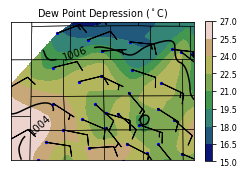

In [16]:
fig=plt.figure(figsize=(3.5,2.4))
maps = Basemap(llcrnrlon=xmin, llcrnrlat=ymin, urcrnrlon=xmax, urcrnrlat=ymax, projection='cyl')
maps.readshapefile(shapefile, name='counties')

plt.contourf(xi, yi, zi, cmap = plt.cm.gist_earth)
c = plt.colorbar()
CS = plt.contour(xi, yi, zi2,colors='k',levels=contour_levels)
plt.clabel(CS, inline=1, fontsize=10,fmt='%3.0f')

maps.scatter(met.loc[time_selection]['Lon'], met.loc[time_selection]['Lat'], marker='o', c='b', s=5)
maps.barbs(  met.loc[time_selection]['Lon'], met.loc[time_selection]['Lat'], 
             met.loc[time_selection]['u'].values*1.94384, met.loc[time_selection]['v'].values*1.94384)

plt.title('Dew Point Depression ($^\circ$C)')

plt.tight_layout()
# filename = '{0}_{1}.png'.format('CBH', time_selection.strftime('%Y%m%d_%H%M'))
# plt.savefig(variables + '/' + filename, dpi=250)
# plt.clf()

### Example for plotting and saving a series of surface plots
Implemented in meso_surface.py which references plotting funtions separately in plotting.py

In [45]:
variable = 'Dewpoint'
plot_dir = 'Meso_loop/{0}'.format(variable) # Change this directory
# os.makedirs(plot_dir)

interval = int((endtime - starttime).total_seconds()/300)

In [46]:
for i in range(interval):
    time_selection = starttime + dt.timedelta(minutes=5*i)

    contour_fillvar  = met.loc[time_selection][variable]
    contour_variable = met.loc[time_selection]['Sea Level Pressure']

    zi = interpolate.griddata((met.loc[time_selection]['Lon'], 
                               met.loc[time_selection]['Lat']), 
                               contour_fillvar[time_selection], 
                               (xi, yi), method='cubic')

    zi2 = interpolate.griddata((met.loc[time_selection]['Lon'], 
                                met.loc[time_selection]['Lat']), 
                                contour_variable[time_selection], 
                                (xi, yi), method='cubic')
    
    fig=plt.figure(figsize=(3.5,2.4))
    maps = Basemap(llcrnrlon=xmin, llcrnrlat=ymin, urcrnrlon=xmax, urcrnrlat=ymax, projection='cyl')
    maps.readshapefile(shapefile, name='counties')

    maps.contourf(xi, yi, zi, np.arange(0,21,1), cmap = plt.cm.gist_earth_r)
    c = plt.colorbar()
    
    CS = maps.contour(xi, yi, zi2,colors='k',levels=np.arange(990,1017,1))
    plt.clabel(CS, inline=1, fontsize=10,fmt='%3.0f')

    maps.scatter(met.loc[time_selection]['Lon'], met.loc[time_selection]['Lat'], marker='o', c='b', s=5)
    maps.barbs(  met.loc[time_selection]['Lon'], met.loc[time_selection]['Lat'], 
                 met.loc[time_selection]['u'].values*1.94384, met.loc[time_selection]['v'].values*1.94384)

    plt.title('Dew Point ($^\circ$C)')
    filename = '{0}_{1}.png'.format(variable, time_selection.strftime('%Y%m%d_%H%M'))
    plt.tight_layout()
    plt.savefig(plot_dir + filename, dpi=250)
    plt.close(fig)

### Basic Meteogram 
See meso_meteogram.py

In [19]:
import parse_mesonet

In [20]:
filename = 'raw_data/CHIL1206.txt'
starttime = dt.datetime(2012,6,15,0)

# To plot a longer time period, change the time delta value below
endtime   = starttime + dt.timedelta(hours=24)
met       = parse_mesonet.MesoArrays(filename).MetArray()[starttime:endtime]

No Agricultural Data Available


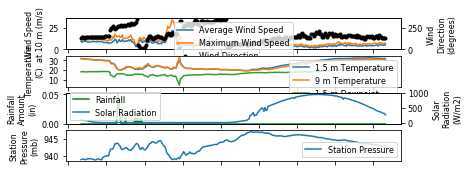

In [21]:
try: 
    agr = MesoArrays(filename).AgrArray()[starttime:endtime]
    fig = plt.figure(1)
    ax1 = fig.add_subplot(611)
    ln1 = ax1.plot(met[starttime:endtime].index, 
                   met['10 m Scalar Wind Speed'][starttime:endtime], 
                   label='Average Wind Speed')
    ln2 = ax1.plot(met[starttime:endtime].index, 
                   met['10 m Gust Wind Speed'][starttime:endtime], 
                   label='Maximum Wind Speed')
    plt.ylabel('Wind Speed\nat 10 m (m/s)', multialignment='center')
    plt.setp(ax1.get_xticklabels(), visible=False)

    ax7 = ax1.twinx()
    ln3 = ax7.plot(met[starttime:endtime].index, 
                   met['10 m Wind Direction'][starttime:endtime], 
                   '.k', linewidth=0.5, label='Wind Direction')
    plt.ylabel('Wind\nDirection\n(degrees)', multialignment='center')
    plt.ylim(0,360)
    lns = ln1+ln2+ln3
    labs = [l.get_label() for l in lns]
    ax7.legend(lns, labs, prop={'size':8})

    ax2 = fig.add_subplot(612, sharex=ax1)
    ax2.plot(met[starttime:endtime].index, 
             met['1.5 m Temperature'][starttime:endtime], 
             label='1.5 m Temperature')
    ax2.plot(met[starttime:endtime].index, 
             met['9 m Temperature'][starttime:endtime], 
             label='9 m Temperature')
    ax2.plot(met[starttime:endtime].index, 
             met['Dewpoint'][starttime:endtime], 
             label='1.5 m Dewpoint')
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('Temperature\n(C)', multialignment='center')
    plt.legend(prop={'size':8})

    ax3 = fig.add_subplot(613, sharex=ax1)
    ln1 = ax3.plot(met[starttime:endtime].index, 
                   met['Rainfall'][starttime:endtime], 
                   'g', label='Rainfall')
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.ylabel('Rainfall\nAmount\n(in)', multialignment='center')
    plt.gca().set_ylim(bottom=0)

    ax8 = ax3.twinx()
    ln2 = ax8.plot(met[starttime:endtime].index, 
                   met['Solar Radiation'][starttime:endtime], 
                   label='Solar Radiation')
    plt.ylabel('Solar\nRadiation\n(W/m2)', multialignment='center')
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax8.legend(lns, labs, prop={'size':8})

    ax4 = fig.add_subplot(614, sharex=ax1)
    ax4.plot(met[starttime:endtime].index, 
             met['Station Pressure'][starttime:endtime], 
             label='Station Pressure')
    plt.setp(ax4.get_xticklabels(), visible=False)
    plt.ylabel('Station\nPressure\n(mb)', multialignment='center')
    plt.legend(prop={'size':8})

    ax5 = fig.add_subplot(615, sharex=ax1)
    ax5.plot(agr[starttime:endtime].index, 
             agr['5 cm Natural Soil Temperature'][starttime:endtime], 
             label='5 cm Soil Temperature')
    ax5.plot(agr[starttime:endtime].index, 
             agr['20 cm Natural Soil Temperature'][starttime:endtime], 
             label='20 cm Soil Temperature')
    plt.setp(ax5.get_xticklabels(), visible=False)
    plt.ylabel('Natural Soil\nTemperature (C)', multialignment='center')
    plt.legend(prop={'size':8})

    ax6 = fig.add_subplot(616, sharex=ax1)
    ax6.plot(agr[starttime:endtime].index, 
             agr['5 cm Water Content'][starttime:endtime], 
             label='5 cm Soil Water Content')
    ax6.plot(agr[starttime:endtime].index, 
             agr['20 cm Water Content'][starttime:endtime], 
             label='20 cm Soil Water Content')
    ax6.plot(agr[starttime:endtime].index, 
             agr['75 cm Water Content'][starttime:endtime], 
             label='75 cm Soil Water Content')
    ax6.plot(agr[starttime:endtime].index, 
             agr['Leaf Wetness'][starttime:endtime], 
             label='Leaf Wetness')
    plt.ylabel('Agricultural\nWater\nContent (%)', multialignment='center')
    plt.xlabel('Time (UTC)')
    plt.legend(prop={'size':8})

except: 
    KeyError
    print ('No Agricultural Data Available')
    fig = plt.figure(1)
    ax1 = fig.add_subplot(611)
    ln1 = ax1.plot(met[starttime:endtime].index, 
                   met['10 m Scalar Wind Speed'][starttime:endtime], 
                   label='Average Wind Speed')
    ln2 = ax1.plot(met[starttime:endtime].index, 
                   met['10 m Gust Wind Speed'][starttime:endtime], 
                   label='Maximum Wind Speed')
    plt.ylabel('Wind Speed\nat 10 m (m/s)', multialignment='center')
    plt.setp(ax1.get_xticklabels(), visible=False)

    ax7 = ax1.twinx()
    ln3 = ax7.plot(met[starttime:endtime].index, 
                   met['10 m Wind Direction'][starttime:endtime], 
                   '.k', linewidth=0.5, label='Wind Direction')
    plt.ylabel('Wind\nDirection\n(degrees)', multialignment='center')
    plt.ylim(0,360)
    lns = ln1+ln2+ln3
    labs = [l.get_label() for l in lns]
    ax7.legend(lns, labs, prop={'size':8})

    ax2 = fig.add_subplot(612, sharex=ax1)
    ax2.plot(met[starttime:endtime].index, 
             met['1.5 m Temperature'][starttime:endtime], 
             label='1.5 m Temperature')
    ax2.plot(met[starttime:endtime].index, 
             met['9 m Temperature'][starttime:endtime], 
             label='9 m Temperature')
    ax2.plot(met[starttime:endtime].index, 
             met['Dewpoint'][starttime:endtime], 
             label='1.5 m Dewpoint')
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('Temperature\n(C)', multialignment='center')
    plt.legend(prop={'size':8})

    ax3 = fig.add_subplot(613, sharex=ax1)
    ln1 = ax3.plot(met[starttime:endtime].index, 
                   met['Rainfall'][starttime:endtime], 
                   'g', label='Rainfall')
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.ylabel('Rainfall\nAmount\n(in)', multialignment='center')
    plt.gca().set_ylim(bottom=0)

    ax8 = ax3.twinx()
    ln2 = ax8.plot(met[starttime:endtime].index, 
                   met['Solar Radiation'][starttime:endtime], 
                   label='Solar Radiation')
    plt.ylabel('Solar\nRadiation\n(W/m2)', multialignment='center')
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax8.legend(lns, labs, prop={'size':8})

    ax4 = fig.add_subplot(614, sharex=ax1)
    ax4.plot(met[starttime:endtime].index, 
             met['Station Pressure'][starttime:endtime], 
             label='Station Pressure')
    plt.setp(ax4.get_xticklabels(), visible=False)
    plt.ylabel('Station\nPressure\n(mb)', multialignment='center')
    plt.legend(prop={'size':8})

plt.show()